In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

In [2]:
from neural_network import NeuralNetwork
from noise_utils import salt_pepper_noise, random_noise, gaussian_noise
from test_utils import generate_test_dataset, train_test, accuracy

# Exercise 3

### Question A

In [3]:
x = np.array([[0, 0],
              [0, 1],
              [1, 0],
              [1, 1]])

y = np.array([[0],
              [1],
              [1],
              [0]])

In [4]:
df = pd.DataFrame(np.concatenate((x, y), axis=1), columns=('x1', 'x2', 'y'))
df.style.hide()

x1,x2,y
0,0,0
0,1,1
1,0,1
1,1,0


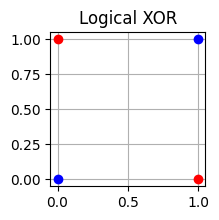

In [5]:
plt.figure(figsize=(2,2))

plt.plot(*x[0], 'o', color='blue')
plt.plot(*x[1], 'o', color='red')
plt.plot(*x[2], 'o', color='red')
plt.plot(*x[3], 'o', color='blue')
plt.grid()
plt.title('Logical XOR')

plt.show()

In [6]:
learning_rate = 0.1
epochs = 10000
nn_A = NeuralNetwork([2, 2, 1], activation_function='sigmoid')
nn_A.train(x, y, learning_rate, epochs, verbose=True)
nn_A.predict(x)

Epoch 0: 0.26269685730159376
Epoch 1000: 0.24977514885285484
Epoch 2000: 0.2483557330056916
Epoch 3000: 0.23390733480289427
Epoch 4000: 0.1815073647181631
Epoch 5000: 0.09064057022271178
Epoch 6000: 0.01770262213748037
Epoch 7000: 0.004963500056472272
Epoch 8000: 0.0020913427309785155
Epoch 9000: 0.0011068053667283894


array([[0],
       [1],
       [1],
       [0]])

### Question B

Load raw data

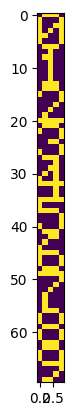

In [7]:
data = np.loadtxt("TP3-ej3-digitos.txt", dtype=np.uint8) 
plt.imshow(data);

Flatten data

In [8]:
data_flattened = data.flatten()
data_flattened = np.reshape(data_flattened, (10, 35))

print(data_flattened.shape)
data_flattened

(10, 35)


array([[0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0],
       [0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0],
       [0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0],
       [0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1,
        1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
       [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0],
       [0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 1, 1, 0, 1

Initialize x input (flattened digit) and y output (result of whether digit is pair)

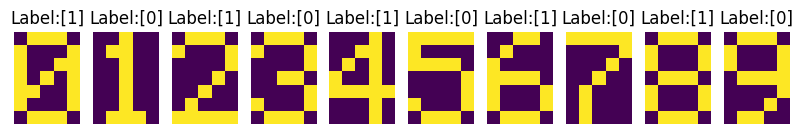

In [9]:
x = data_flattened
y = np.array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0]).reshape(-1, 1)

plt.figure(figsize=(10, 3))
for i, img in enumerate(data_flattened):
    plt.subplot(1, 10, i+1)
    plt.title('Label:' + str(y[i]))
    plt.axis('off')
    plt.imshow(np.reshape(img, (7,5)))

In [10]:
learning_rate = 0.1
epochs = 10000

nn_B = NeuralNetwork([35, 10, 1])
nn_B.train(x, y, learning_rate, epochs, verbose=True)
nn_B.predict(x)

Epoch 0: 0.4897114208480954
Epoch 1000: 0.24977573422476876
Epoch 2000: 0.24950212009211953
Epoch 3000: 0.24804815388305418
Epoch 4000: 0.013335455128936607
Epoch 5000: 0.0011336567715793562
Epoch 6000: 0.0003632312035137448
Epoch 7000: 0.00017403536579955705
Epoch 8000: 0.00010108751186730979
Epoch 9000: 6.571629751658338e-05


array([[1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0]])

digit is even: [[0]]


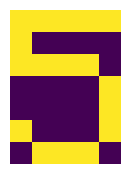

In [11]:
digit = 5

plt.figure(figsize=(2,2))
plt.imshow(np.reshape(data_flattened[digit], (7,5)));
plt.axis('off')
res = nn_B.predict(data_flattened[digit])
print('digit is even:', res)

### Exercise C

Initialize data
- x: 10*35 (10 digits * 35 pixels each)
- y: 10*1 (can be classified to 10 possible digits)

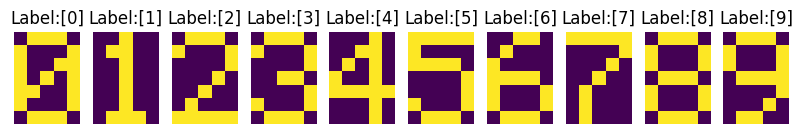

In [12]:
x = data_flattened
y = np.arange(10).reshape(-1, 1)

plt.figure(figsize=(10, 3))
for i, img in enumerate(data_flattened):
    plt.subplot(1, 10, i+1)
    plt.title('Label:' + str(y[i]))
    plt.axis('off')
    plt.imshow(np.reshape(img, (7,5)))

In [13]:
input_size = 35
hidden_size = 10
output_size = 10

learning_rate = 0.1
epochs = 100000

nn_C = NeuralNetwork([35, 10, 10], one_hot=True, activation_function='sigmoid')
nn_C.train(x, y, learning_rate, epochs, verbose=True)
nn_C.predict(x)

Epoch 0: 0.8829492046543854
Epoch 10000: 0.0899710356501191
Epoch 20000: 0.08300377929691581
Epoch 30000: 0.08046809700406797
Epoch 40000: 0.07391432019169498
Epoch 50000: 0.03725268528787298
Epoch 60000: 0.019187834052284934
Epoch 70000: 0.012592700772283279
Epoch 80000: 0.008752315497401237
Epoch 90000: 0.004524448572738427


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

digit is: [7]


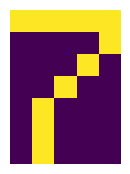

In [14]:
digit = 7

plt.figure(figsize=(2,2))
plt.axis('off')
plt.imshow(np.reshape(data_flattened[digit], (7,5)));
res = nn_C.predict(data_flattened[digit])
print('digit is:', res)

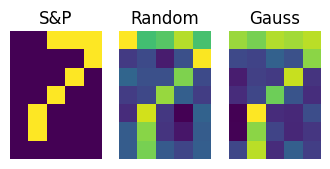

In [15]:
salt_pepper_digit = salt_pepper_noise(data_flattened[digit], 0.05, 0.05)
random_digit = random_noise(data_flattened[digit], 5)
gauss_digit = gaussian_noise(data_flattened[digit], 0.1, 0.1)

noised_data = [salt_pepper_digit, random_digit, gauss_digit]
titles = ['S&P', 'Random', 'Gauss']

plt.figure(figsize=(4,3))
for i, img in enumerate(noised_data):
    plt.subplot(1, 3, i+1)
    plt.title(titles[i])
    plt.axis('off')
    plt.imshow(np.reshape(img, (7,5)));

In [16]:
nn_C.predict(salt_pepper_digit)

array([7])

# Analysis / graphs

## 3a

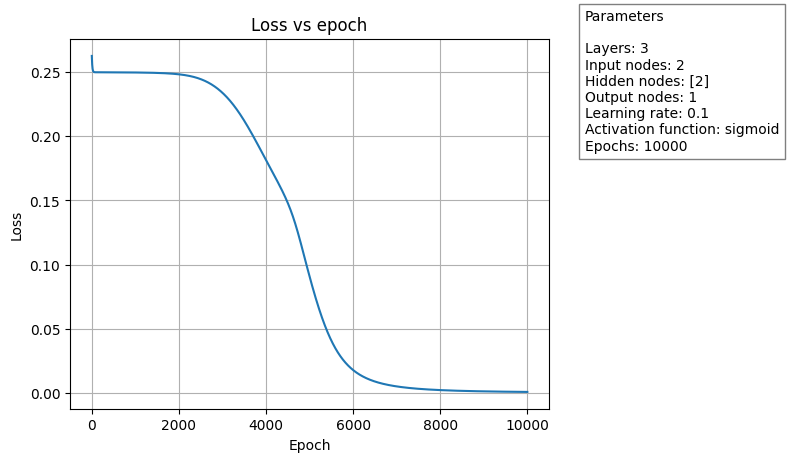

In [17]:
nn_A.graph('loss')

## 3b

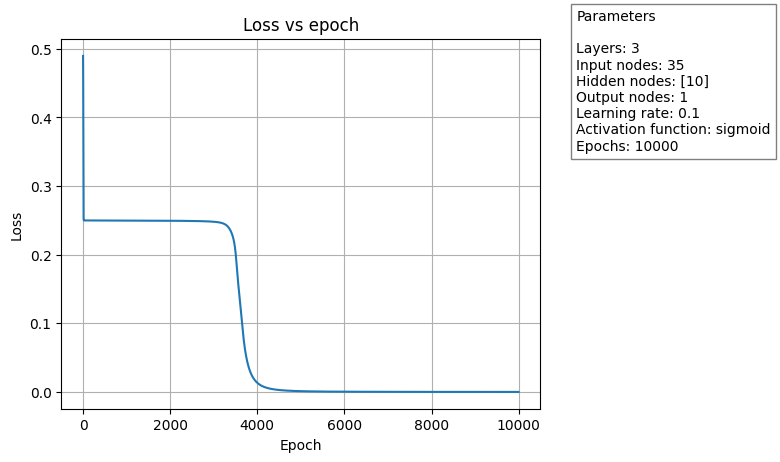

In [18]:
nn_B.graph(graph_type='loss')

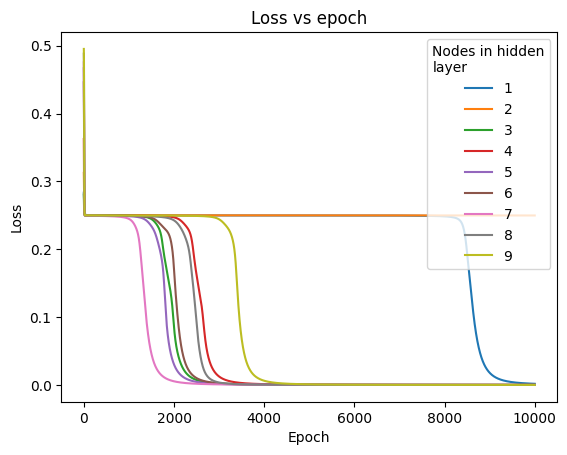

In [19]:
x = data_flattened
y = np.array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0]).reshape(-1, 1)
learning_rate = 0.1
epochs = 10000

losses = []

for i in np.arange(1, 10):
    nn = NeuralNetwork([35, i, 1])
    nn.train(x, y, learning_rate, epochs)
    plt.plot(nn.losses)
plt.legend(np.arange(1, 10), title='Nodes in hidden\nlayer')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Loss vs epoch')
plt.show()

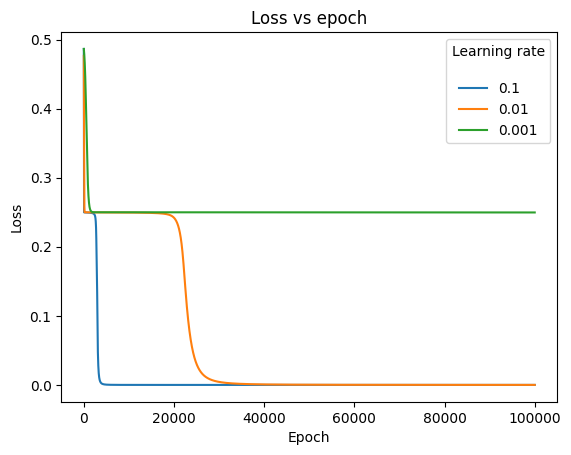

In [20]:
x = data_flattened
y = np.array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0]).reshape(-1, 1)
learning_rates = [0.1, 0.01, 0.001]
epochs = 100000

losses = []

for learning_rate in learning_rates:
    nn = NeuralNetwork([35, i, 1])
    nn.train(x, y, learning_rate, epochs)
    plt.plot(nn.losses)
plt.legend(learning_rates, title='Learning rate\n')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Loss vs epoch')
plt.show()

## 3c

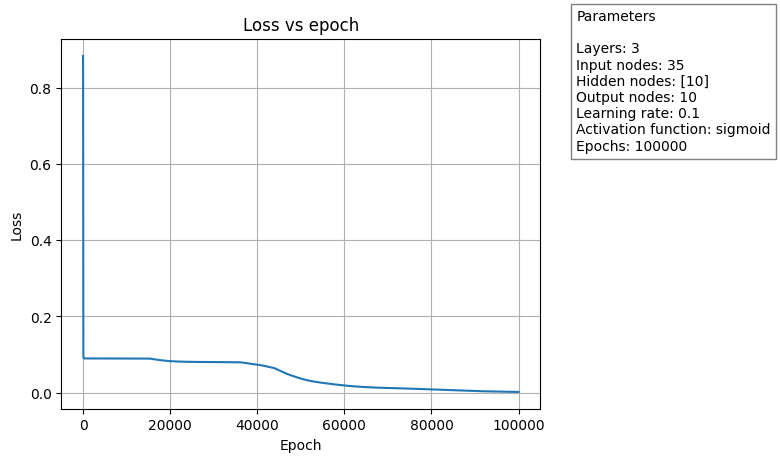

In [21]:
nn_C.graph('loss')

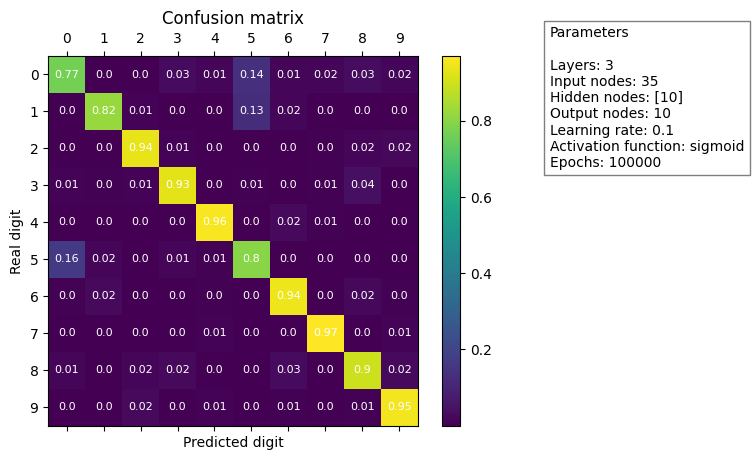

In [22]:
nn_C.graph(graph_type='confusion')

## Train test

In [23]:
num_values = 100
dataX, dataY = generate_test_dataset(num_values, data_flattened)
dataX_train, dataY_train, dataX_test, dataY_test = train_test(dataX, dataY, num_values, 0.75)

In [24]:
learning_rate = 0.1
epochs = 100000

nn = NeuralNetwork([35, 10, 10], one_hot=True, activation_function='sigmoid')
nn.train(dataX_train, dataY_train, learning_rate, epochs, verbose=True)

Epoch 0: 0.8775346993082733
Epoch 10000: 0.08869359102955676
Epoch 20000: 0.06285277590904802
Epoch 30000: 0.026166909298313314
Epoch 40000: 0.0074384935765936825
Epoch 50000: 0.003288118492333386
Epoch 60000: 0.001897204122925365
Epoch 70000: 0.0009658518757323069
Epoch 80000: 0.0005064102606534021
Epoch 90000: 0.000296448957656972


In [25]:
predictions = nn.predict(dataX_test)
accuracy(predictions, dataY_test)

1.0

### Noised

#### Salt pepper

In [26]:
num_values = 100

salt = 0.05
pepper = 0.05

dataX, dataY = generate_test_dataset(num_values, data_flattened, noise_type='salt_pepper', salt_probability=salt, pepper_probability=pepper)
dataX_train, dataY_train, dataX_test, dataY_test = train_test(dataX, dataY, num_values, 0.75)

In [27]:
learning_rate = 0.1
epochs = 100000

nn = NeuralNetwork([35, 10, 10], one_hot=True, activation_function='sigmoid')
nn.train(dataX_train, dataY_train, learning_rate, epochs, verbose=True)

Epoch 0: 0.8850796455636979
Epoch 10000: 0.08959918777195969
Epoch 20000: 0.08065836052632522
Epoch 30000: 0.06399676790116128
Epoch 40000: 0.04290728766947198
Epoch 50000: 0.00912354827561555
Epoch 60000: 0.003204189890850004
Epoch 70000: 0.0015291296869140076
Epoch 80000: 0.0008356309763060068
Epoch 90000: 0.0005049937315456577


In [28]:
predictions = nn.predict(dataX_test)
accuracy(predictions, dataY_test)

1.0

In [29]:
num_values = 100
split_rate = 0.70
learning_rate = 0.1
epochs = 100000

salts = np.arange(0.05, 0.5, 0.05)
peppers = np.arange(0.05, 0.5, 0.05)

accuracies = []

for salt, pepper in zip(salts, peppers):
    print(salt, pepper)
    
    dataX, dataY = generate_test_dataset(num_values, data_flattened, noise_type='salt_pepper', salt_probability=salt, pepper_probability=pepper)
    dataX_train, dataY_train, dataX_test, dataY_test = train_test(dataX, dataY, num_values, split_rate)
    
    nn = NeuralNetwork([35, 10, 10], one_hot=True, activation_function='sigmoid')
    nn.train(dataX_train, dataY_train, learning_rate, epochs)

    predictions = nn.predict(dataX_test)
    accuracy_result = accuracy(predictions, dataY_test)
    print('= ', accuracy_result)

    accuracies.append([accuracy_result])

0.05 0.05
=  0.9
0.1 0.1
=  0.9666666666666667
0.15000000000000002 0.15000000000000002
=  0.7666666666666667
0.2 0.2
=  0.8666666666666667
0.25 0.25
=  0.8
0.3 0.3
=  0.5333333333333333
0.35000000000000003 0.35000000000000003
=  0.26666666666666666
0.4 0.4
=  0.3
0.45 0.45
=  0.3333333333333333


In [30]:
def info_box(nn, samples, split_rate):
    train_rate = round(split_rate*100, 1)
    test_rate = round(100-split_rate*100, 1)
    parameters = (
        'Parameters\n\n'
        f'Layers: {nn.num_layers}\n'
        f'Input nodes: {nn.layer_sizes[0]}\n'
        f'Hidden nodes: {nn.layer_sizes[1:-1]}\n'
        f'Output nodes: {nn.layer_sizes[-1]}\n'
        f'Learning rate: {nn.learning_rate}\n'
        f'Activation function: {nn.activation_function}\n'
        f'Epochs: {nn.epochs}\n'
        f'\nTrain / test'
        f'\nSamples: {samples}'
        f'\nTrain/test split: {train_rate}% / {test_rate}%'
    )
    fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [8, 2]}, figsize=(8.5, 4.8))
    ax2.text(-0.2, 0.5, parameters, bbox=dict(facecolor='white', alpha=0.5), transform=ax2.transAxes)
    ax2.axis('off')
    
    return ax1

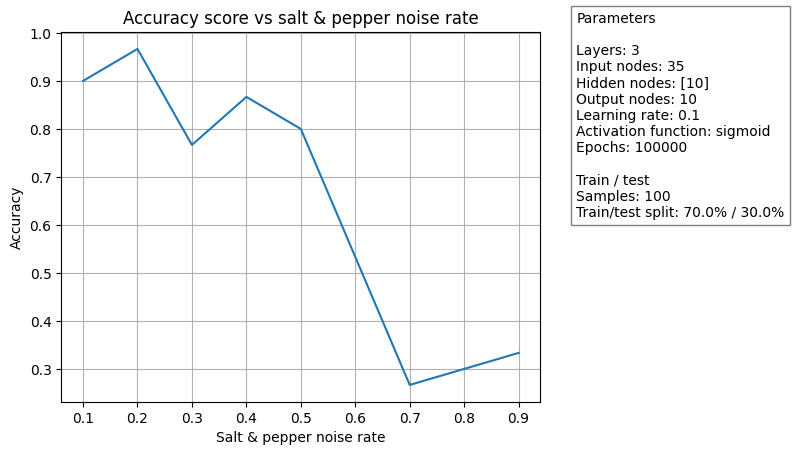

In [31]:
ax1 = info_box(nn, num_values, split_rate)

ax1.plot(salts+peppers, accuracies)
ax1.set_xlabel('Salt & pepper noise rate')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy score vs salt & pepper noise rate')
ax1.grid()
plt.show()

### Gaussian

In [32]:
num_values = 100
split_rate = 0.70
learning_rate = 0.1
epochs = 100000

mean = 0
stds = np.arange(0, 0.5, 0.05)

accuracies = []

for std in stds:    
    print(std)
    dataX, dataY = generate_test_dataset(num_values, data_flattened, noise_type='gauss', mean=mean, std=std)
    dataX_train, dataY_train, dataX_test, dataY_test = train_test(dataX, dataY, num_values, split_rate)
    
    nn = NeuralNetwork([35, 10, 10], one_hot=True, activation_function='sigmoid')
    nn.train(dataX_train, dataY_train, learning_rate, epochs)

    predictions = nn.predict(dataX_test)
    accuracy_result = accuracy(predictions, dataY_test)
    print('= ', accuracy_result)

    accuracies.append([accuracy_result])

0.0
=  1.0
0.05
=  1.0
0.1
=  1.0
0.15000000000000002
=  1.0
0.2
=  1.0
0.25
=  1.0
0.30000000000000004
=  0.9333333333333333
0.35000000000000003
=  0.9333333333333333
0.4
=  1.0
0.45
=  0.8666666666666667


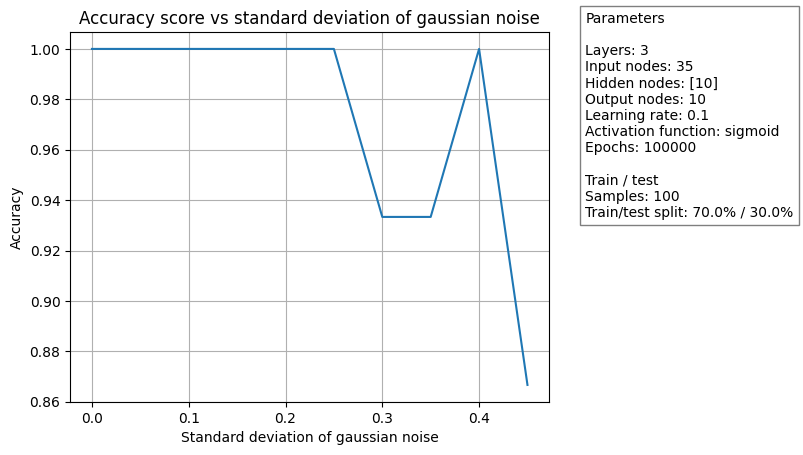

In [33]:
ax1 = info_box(nn, num_values, split_rate)

ax1.plot(stds, accuracies)
ax1.set_xlabel('Standard deviation of gaussian noise')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy score vs standard deviation of gaussian noise')
ax1.grid()
plt.show()

In [34]:
num_values = 100
split_rate = 0.70
learning_rate = 0.1
epochs = 100000

means = np.arange(0, 0.5, 0.05)
std = 0.1

accuracies = []

for mean in means:    
    print(std)
    dataX, dataY = generate_test_dataset(num_values, data_flattened, noise_type='gauss', mean=mean, std=std)
    dataX_train, dataY_train, dataX_test, dataY_test = train_test(dataX, dataY, num_values, split_rate)
    
    nn = NeuralNetwork([35, 10, 10], one_hot=True, activation_function='sigmoid')
    nn.train(dataX_train, dataY_train, learning_rate, epochs)

    predictions = nn.predict(dataX_test)
    accuracy_result = accuracy(predictions, dataY_test)
    print('= ', accuracy_result)

    accuracies.append([accuracy_result])

0.1
=  1.0
0.1
=  0.8333333333333334
0.1
=  0.8333333333333334
0.1
=  0.5
0.1
=  0.06666666666666667
0.1
=  0.13333333333333333
0.1
=  0.1
0.1
=  0.1
0.1
=  0.13333333333333333
0.1
=  0.13333333333333333


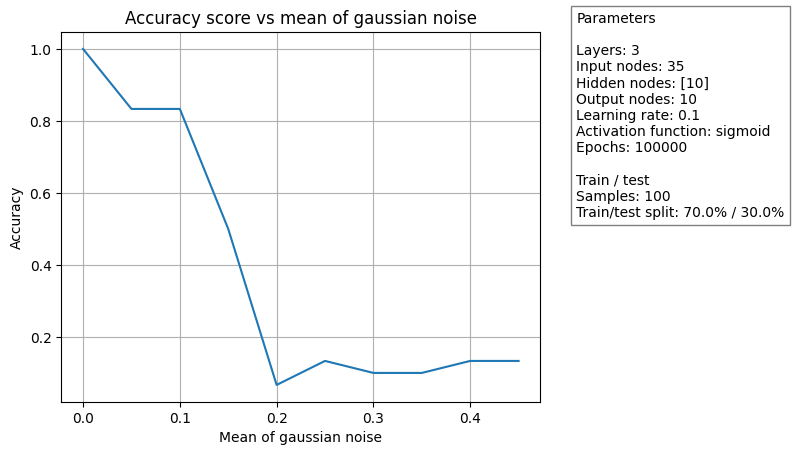

In [35]:
ax1 = info_box(nn, num_values, split_rate)

ax1.plot(stds, accuracies)
ax1.set_xlabel('Mean of gaussian noise')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy score vs mean of gaussian noise')
ax1.grid()
plt.show()

### Random

In [36]:
num_values = 100
split_rate = 0.70
learning_rate = 0.1
epochs = 100000

factors = np.arange(0, 1, 0.1)
accuracies = []

for factor in factors:
    print(factor)
    dataX, dataY = generate_test_dataset(num_values, data_flattened, noise_type='random', factor=factor)
    dataX_train, dataY_train, dataX_test, dataY_test = train_test(dataX, dataY, num_values, split_rate)
    
    nn = NeuralNetwork([35, 10, 10], one_hot=True, activation_function='sigmoid')
    nn.train(dataX_train, dataY_train, learning_rate, epochs)

    predictions = nn.predict(dataX_test)
    accuracy_result = accuracy(predictions, dataY_test)
    print('= ', accuracy_result)

    accuracies.append([accuracy_result])

0.0
=  1.0
0.1
=  1.0
0.2
=  1.0
0.30000000000000004
=  1.0
0.4
=  1.0
0.5
=  1.0
0.6000000000000001
=  1.0
0.7000000000000001
=  1.0
0.8
=  1.0
0.9
=  0.9333333333333333


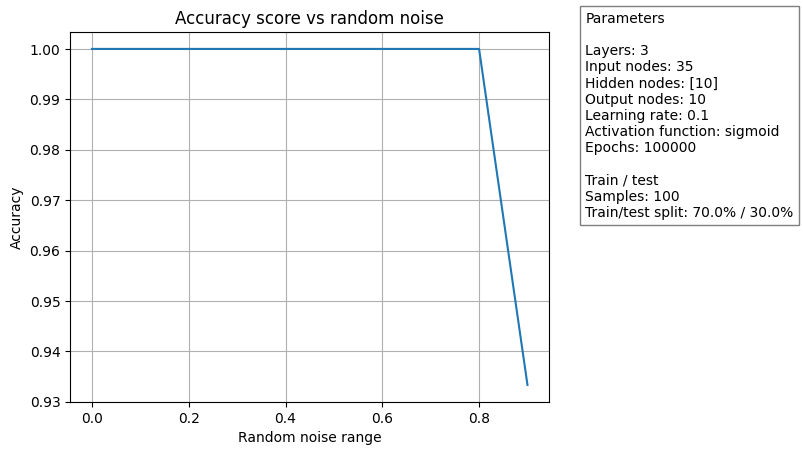

In [37]:
ax1 = info_box(nn, num_values, split_rate)

ax1.plot(factors, accuracies)
ax1.set_xlabel('Random noise range')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy score vs random noise')
ax1.grid()
plt.show()

In [38]:
num_values = 100
split_rate = 0.70
learning_rate = 0.1
epochs = 100000

pepper = 0.05
salt = 0.05
nodes = np.arange(1, 16)

accuracies = []

for node in nodes:    
    print(node)
    dataX, dataY = generate_test_dataset(num_values, data_flattened, noise_type='salt_pepper', salt_probability=salt, pepper_probability=pepper)
    dataX_train, dataY_train, dataX_test, dataY_test = train_test(dataX, dataY, num_values, split_rate)
    
    nn = NeuralNetwork([35, node, 10], one_hot=True, activation_function='sigmoid')
    nn.train(dataX_train, dataY_train, learning_rate, epochs)

    predictions = nn.predict(dataX_test)
    accuracy_result = accuracy(predictions, dataY_test)
    print('= ', accuracy_result)

    accuracies.append([accuracy_result])

1
=  0.16666666666666666
2
=  0.26666666666666666
3
=  0.36666666666666664
4
=  0.8333333333333334
5
=  0.9666666666666667
6
=  0.9333333333333333
7
=  0.9666666666666667
8
=  0.9666666666666667
9
=  0.8666666666666667
10
=  1.0
11
=  1.0
12
=  0.9666666666666667
13
=  1.0
14
=  1.0
15
=  0.9666666666666667


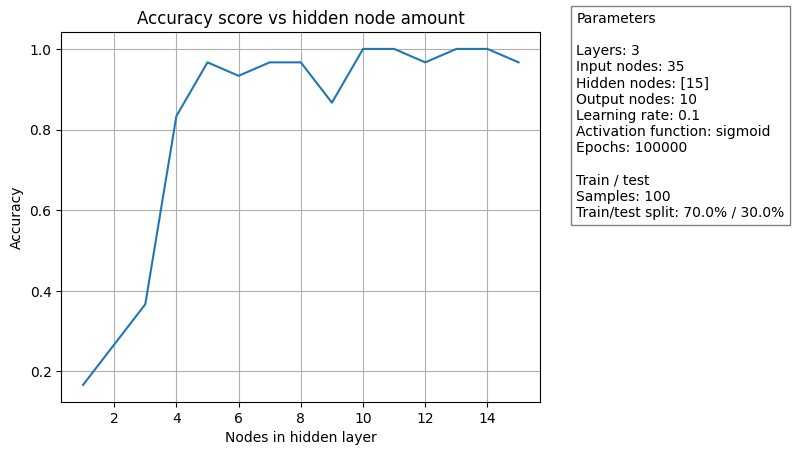

In [39]:
ax1 = info_box(nn, num_values, split_rate)

ax1.plot(nodes, accuracies)
ax1.set_xlabel('Nodes in hidden layer')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy score vs hidden node amount')
ax1.grid()
plt.show()

In [ ]:
num_values = 100
split_rate = 0.70
learning_rate = 0.1
epochs = 100000

mean = 0.1
std = 0.1
layers = np.arange(1, 10)

accuracies = []

for layer in layers:    
    print(np.repeat(10, layer))
    dataX, dataY = generate_test_dataset(num_values, data_flattened, noise_type='gauss', mean=mean, std=std)
    dataX_train, dataY_train, dataX_test, dataY_test = train_test(dataX, dataY, num_values, split_rate)
    
    nn = NeuralNetwork([35, *np.repeat(10, layer), 10], one_hot=True, activation_function='sigmoid')
    nn.train(dataX_train, dataY_train, learning_rate, epochs)

    predictions = nn.predict(dataX_test)
    accuracy_result = accuracy(predictions, dataY_test)
    print('= ', accuracy_result)

    accuracies.append([accuracy_result])